## Outputting to multiple destinations

Like how in python the output of a function can be used multiple times, the output of a Deltaflow node
can also be used by multiple other nodes.

Let's start with defining a few nodes:

In [1]:
from deltalanguage.lib import StateSaver
from deltalanguage.runtime import DeltaPySimulator
from deltalanguage.wiring import DeltaBlock, DeltaGraph


@DeltaBlock()
def foo() -> int:
    return 10

@DeltaBlock()
def bar(a: int) -> int:
    return a*2

@DeltaBlock()
def adder(a: int, b: int) -> int:
    return a + b

s = StateSaver(verbose=True) # helper node that saves the result

Now let's connect these nodes into a graph:

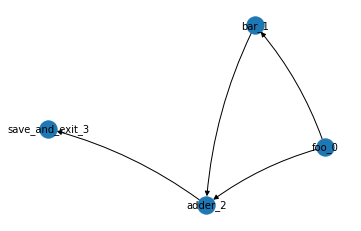

In [2]:
with DeltaGraph() as graph:
    foo_out = foo()
    bar_out = bar(foo_out)
    s.save_and_exit(adder(foo_out, bar_out))

graph.draw(seed=32)

Note that in this simple graph the node, whose output is reused, has two output edges, even though it has only one output!

A more detailed representation of the same graph also confirms multiple ouput channels from the same node:

In [3]:
print(graph)

DeltaGraph[main] {
    foo_0:
        out: (bar_1.a, DInt32)
        out: (adder_2.a, DInt32)
    bar_1:
        in : (a, DInt32, 0, False)
        out: (adder_2.b, DInt32)
    adder_2:
        in : (a, DInt32, 0, False)
        in : (b, DInt32, 0, False)
        out: (save_and_exit_3.val, DInt32)
    save_and_exit_3:
        in : (val, T, 0, False)
}



However this graph is correct and can be used by a runtime:

In [4]:
rt = DeltaPySimulator(graph)
rt.run()

# check the result: 
assert s.saved == [30]

saving 30


What happens is the following:

- This version of a runtime recognises that
  an output is reused and creates an proxy splitter node that accmodates this process.
  
- All other supported runtimes have the same rules and thus the same graph can be used with them as well.

Here is how the expanded graph looks under the hood:

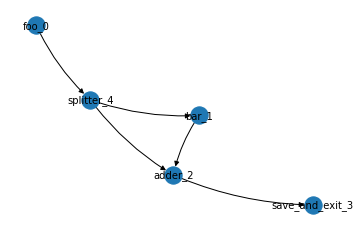

In [5]:
graph.do_automatic_splitting()
graph.draw(seed=32)

It is worth noting that splitter nodes use forked returns to create unique outputs for each node under the hood.
This should not be a concern for users as it happens automatically and consistently across all runtimes.